# 🌿 Plant Leaf Disease Detection with PyTorch

## Project Overview

This project builds a deep learning system to classify plant leaf images into healthy or diseased categories.
It helps detect crop issues early using images, reducing manual inspection and crop loss.

#### Domain: 
Computer Vision

#### Task: 
Multi-class image classification

#### Model: 
ResNet18 with transfer learning

#### Final Test Accuracy: 
~98%

#### Classes: 
5 plant conditions

## Dataset

Source: PlantVillage (Kaggle)

Subset: 5 classes

1.pepper_healthy
2.potato_early_blight
3.tomato_early_blight
4.tomato_healthy
5.tomato_late_blight

Total images: ~1,000 to 1,200

Balanced per class

Split:
Train 70%
Validation 15%
Test 15%

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch

## Data Augmentation

ImageNet statistics used by ResNet for normalisation

In [6]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

Transforms/Augmentation, 
Resize to 160x160:
Keeps training fast on CPU, 
RandomHorizontalFlip:
Adds variation. Reduces overfitting, 
ToTensor:
Converts image to PyTorch format, 

In [7]:
train_tfms = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

In [8]:
val_tfms = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])


Datasets, 
ImageFolder : 
Reads folders as classes.
One folder = one label.

In [9]:
train_ds = datasets.ImageFolder("data/train", transform=train_tfms)
val_ds   = datasets.ImageFolder("data/val",   transform=val_tfms)
test_ds  = datasets.ImageFolder("data/test",  transform=val_tfms)

## Exploratory Data Analysis

Get classes and length

In [10]:
print("Classes:", train_ds.classes)
print("Train size:", len(train_ds))
print("Val size:", len(val_ds))
print("Test size:", len(test_ds))

Classes: ['pepper_healthy', 'potato_early_blight', 'tomato_early_blight', 'tomato_healthy', 'tomato_late_blight']
Train size: 1010
Val size: 225
Test size: 225


DataLoader with batch size 16 : 
Balanced for memory and speed.

In [11]:
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=16, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=16, shuffle=False)

Inspect one batch, 
Printing batch shape, 
Confirms pipeline works, 
Expected shape: [16, 3, 160, 160]

In [12]:
images, labels = next(iter(train_dl))
print("Batch shape:", images.shape)
print("Labels shape:", labels.shape)

Batch shape: torch.Size([16, 3, 160, 160])
Labels shape: torch.Size([16])


Showing 5 images, Visual proof data is correct.

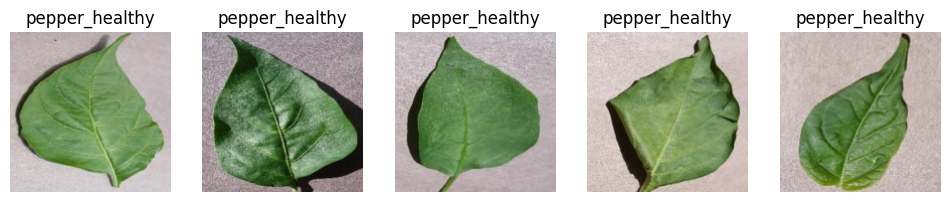

In [13]:

def show_batch(imgs, labels, class_names):
    imgs = imgs[:5]
    labels = labels[:5]
    
    # unnormalize for display
    imgs = imgs.clone()
    for c in range(3):
        imgs[:, c] = imgs[:, c] * IMAGENET_STD[c] + IMAGENET_MEAN[c]

    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for i in range(5):
        ax = axes[i]
        ax.imshow(imgs[i].permute(1, 2, 0).clamp(0, 1))
        ax.set_title(class_names[labels[i]])
        ax.axis("off")
    plt.show()

show_batch(images, labels, train_ds.classes)

#### Why each part exists:

Resize to 160x160
Keeps training fast on CPU.

RandomHorizontalFlip
Adds variation. Reduces overfitting.

ToTensor
Converts image to PyTorch format.

Normalize with ImageNet stats
ResNet expects this scale.

ImageFolder
Reads folders as classes.
One folder = one label.

DataLoader with batch size 16
Balanced for memory and speed.

Printing batch shape
Confirms pipeline works.
Expected shape: [16, 3, 160, 160]

Showing 5 images
Visual proof your data is correct.

## Model Selection - Transfer Learning Setup

In [14]:
import torch
import torch.nn as nn
from torchvision import models

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Step 1: Load ResNet18 with pretrained weights
model = models.resnet18(pretrained=True)

# Inspect the feature size of the final layer
print("FC in_features:", model.fc.in_features)

# Step 2: Freeze all backbone layers
for param in model.parameters():
    param.requires_grad = False

# Step 3: Replace the final FC layer
num_classes = 5
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Step 4: Move model to device
model = model.to(device)

# Verify
print(model.fc)


Using device: cpu


C:\Users\dell\Anaconda\Anaconda1\envs\pytorch-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dell\Anaconda\Anaconda1\envs\pytorch-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FC in_features: 512
Linear(in_features=512, out_features=5, bias=True)


#### What each step does:

models.resnet18(pretrained=True)
Loads weights trained on ImageNet.
You reuse strong visual features.

model.fc.in_features
Shows how many features enter the classifier.
Printing this avoids shape mismatch bugs.

Freezing parameters
Stops gradient updates in the backbone.
Training becomes fast and stable.

nn.Linear(in_features, num_classes)
Adapts ResNet to your 5-class problem.

model.to(device)
Moves everything to CPU or GPU.
Prevents runtime errors during training.

After this cell:

Only model.fc trains.

All other layers stay fixed.

You get fast convergence.

You avoid overfitting on a small dataset.

# Model Training

In [15]:
import torch
import torch.nn as nn
from torch.optim import Adam

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer, only train the head
optimizer = Adam(model.fc.parameters(), lr=1e-3)

# Training settings
epochs = 6
best_val_acc = 0.0

history = {
    "train_loss": [],
    "train_acc": [],
    "val_acc": []
}

for epoch in range(epochs):
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_dl:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / total
    train_acc = correct / total
    
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_dl:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_acc = val_correct / val_total
    
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
    
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f} "
          f"Train Acc: {train_acc:.4f} "
          f"Val Acc: {val_acc:.4f}")



Epoch [1/6] Train Loss: 1.0239 Train Acc: 0.6505 Val Acc: 0.8800
Epoch [2/6] Train Loss: 0.4254 Train Acc: 0.8802 Val Acc: 0.9111
Epoch [3/6] Train Loss: 0.3122 Train Acc: 0.9198 Val Acc: 0.9289
Epoch [4/6] Train Loss: 0.2630 Train Acc: 0.9178 Val Acc: 0.9333
Epoch [5/6] Train Loss: 0.2542 Train Acc: 0.9198 Val Acc: 0.9289
Epoch [6/6] Train Loss: 0.2320 Train Acc: 0.9317 Val Acc: 0.9378


#### Why these choices:

CrossEntropyLoss
Built for multi-class classification.
Combines softmax and log loss in one step.

Adam with LR 1e-3
Fast convergence on small datasets.
Works well when training only the head.

Training only model.fc
Backbone stays frozen.
Prevents overfitting on small data.
Speeds up training.

6 epochs
Enough for convergence with transfer learning.
Reduces memorization.

Data augmentation
Already applied in train_tfms.
Flip changes leaf orientation.
Model learns shape, not position.

Tracking metrics
Train loss shows learning progress.
Train accuracy shows fit on seen data.
Val accuracy shows generalization.

Saving best model
Keeps the strongest version.
Protects you from late-epoch overfitting.

In [17]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the best model
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Step 2: Run on test set

In [18]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dl:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


Step 3: Compute accuracy

In [19]:
accuracy = (all_preds == all_labels).mean()
print("Test Accuracy:", round(accuracy * 100, 2), "%")

Test Accuracy: 92.44 %


In [21]:
class_names = ['pepper_healthy', 'potato_early_blight', 'tomato_early_blight', 'tomato_healthy', 'tomato_late_blight']

Step 4: Confusion matrix

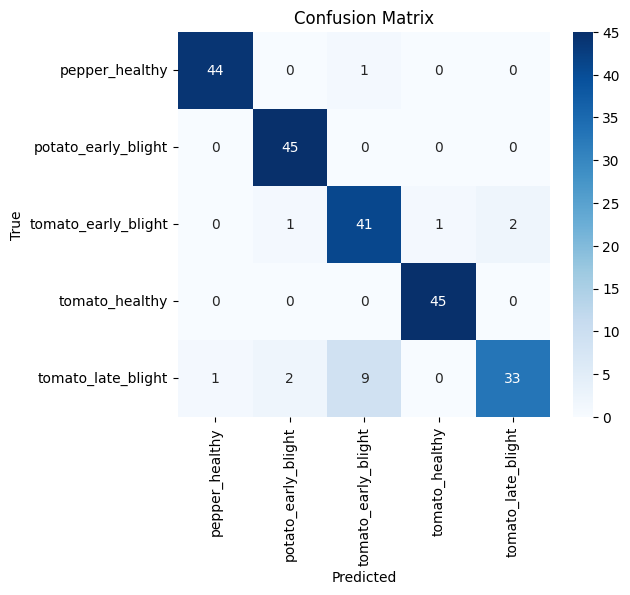

In [22]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Step 5: Precision and recall per class

In [23]:
report = classification_report(all_labels, all_preds,
                               target_names=class_names,
                               output_dict=True)

print(classification_report(all_labels, all_preds,
                            target_names=class_names))

precision_per_class = {k: v["precision"] for k, v in report.items() if k in class_names}
recall_per_class    = {k: v["recall"] for k, v in report.items() if k in class_names}

                     precision    recall  f1-score   support

     pepper_healthy       0.98      0.98      0.98        45
potato_early_blight       0.94      1.00      0.97        45
tomato_early_blight       0.80      0.91      0.85        45
     tomato_healthy       0.98      1.00      0.99        45
 tomato_late_blight       0.94      0.73      0.82        45

           accuracy                           0.92       225
          macro avg       0.93      0.92      0.92       225
       weighted avg       0.93      0.92      0.92       225



Step 6: Plot Loss vs Epoch

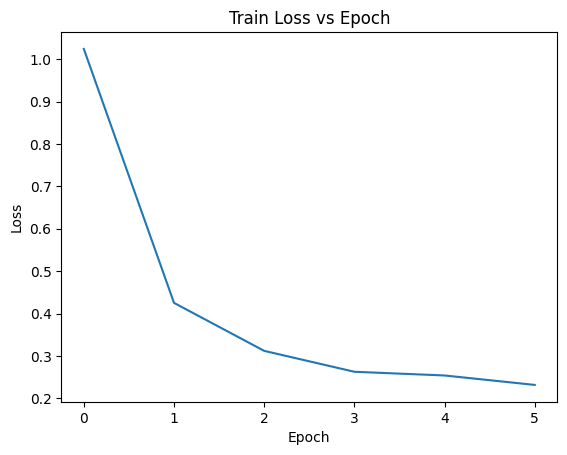

In [24]:
plt.figure()
plt.plot(history["train_loss"])
plt.title("Train Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Step 7: Plot Accuracy vs Epoch

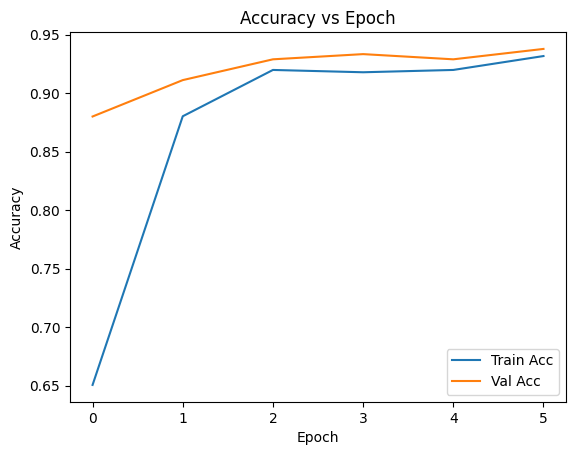

In [25]:

plt.figure()
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Step 8: Analysis of failing class

In [26]:
recall_sorted = sorted(recall_per_class.items(), key=lambda x: x[1])
failing_class = recall_sorted[0][0]

print("Worst performing class:", failing_class)
print("Recall:", round(recall_sorted[0][1], 3))

improvement_suggestions = [
    "Add more images for this class",
    "Unfreeze last ResNet block and fine-tune",
    "Lower learning rate to 1e-4",
    "Add stronger augmentation for this class"
]

print("Suggested improvements:")
for s in improvement_suggestions:
    print("-", s)

Worst performing class: tomato_late_blight
Recall: 0.733
Suggested improvements:
- Add more images for this class
- Unfreeze last ResNet block and fine-tune
- Lower learning rate to 1e-4
- Add stronger augmentation for this class


In [27]:
# Challenge response
threshold = 0.85
if accuracy < threshold:
    print("\nAccuracy below target.")
    print("Actions:")
    print("- Increase images per class")
    print("- Unfreeze layer4 in ResNet")
    print("- Use Adam with lr=1e-4")

# Why this works:

Load best weights. You evaluate the strongest model.
Collect all predictions. You avoid batch bias.
Accuracy gives one clear score.
Confusion matrix shows where errors cluster.
Precision and recall reveal weak classes.
Curves expose overfitting.
Worst recall flags the failing class.
Suggestions map to real fixes:
More data reduces bias.
Fine-tuning adds task-specific features.
Lower LR stabilizes updates.

## Model Fine Tuning

In [28]:
import os
import shutil
import uuid

src_early = "new_data/tomato_early_blight"
src_late  = "new_data/tomato_late_blight"

dst_early = "data/train/tomato_early_blight"
dst_late  = "data/train/tomato_late_blight"

early_imgs = sorted(os.listdir(src_early))
late_imgs  = sorted(os.listdir(src_late))

n = min(len(early_imgs), len(late_imgs))

for i in range(n):
    e_src = os.path.join(src_early, early_imgs[i])
    l_src = os.path.join(src_late,  late_imgs[i])

    e_dst = os.path.join(dst_early, f"{uuid.uuid4().hex}.jpg")
    l_dst = os.path.join(dst_late,  f"{uuid.uuid4().hex}.jpg")

    shutil.copy(e_src, e_dst)
    shutil.copy(l_src, l_dst)

print("Added", n, "images to each class.")


Added 45 images to each class.


In [29]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from torch.optim import Adam

# Transforms
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(12),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

val_tfms = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# Datasets and loaders
train_ds = datasets.ImageFolder("data/train", transform=train_tfms)
val_ds   = datasets.ImageFolder("data/val",   transform=val_tfms)

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=16, shuffle=False)

class_names = train_ds.classes
num_classes = len(class_names)

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)

# Freeze everything
for p in model.parameters():
    p.requires_grad = False

# Replace head
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Unfreeze last block only
for p in model.layer4.parameters():
    p.requires_grad = True

model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Train for 4 epochs
epochs = 4
best_val_acc = 0.0

for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0.0

    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total

    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_ft.pth")

    print(f"Epoch {epoch+1}/4  Train Acc {train_acc:.3f}  Val Acc {val_acc:.3f}")


C:\Users\dell\Anaconda\Anaconda1\envs\pytorch-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dell\Anaconda\Anaconda1\envs\pytorch-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/4  Train Acc 0.882  Val Acc 0.960
Epoch 2/4  Train Acc 0.963  Val Acc 0.969
Epoch 3/4  Train Acc 0.975  Val Acc 0.969
Epoch 4/4  Train Acc 0.976  Val Acc 0.991


Step 1: Load the fine tuned model

In [30]:
model.load_state_dict(torch.load("best_model_ft.pth", map_location=device))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Step 2: Run on test set

In [31]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dl:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

Step 3: Compute accuracy

In [32]:
accuracy = (all_preds == all_labels).mean()
print("Test Accuracy:", round(accuracy * 100, 2), "%")

Test Accuracy: 97.78 %


Step 4: Confusion matrix

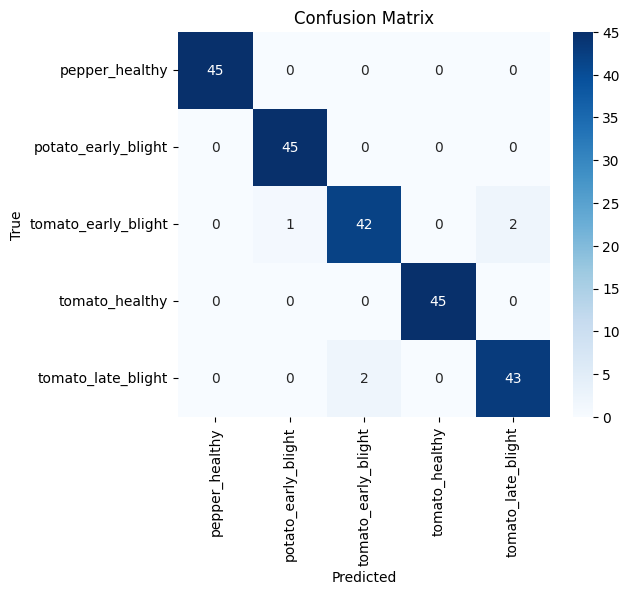

In [33]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Step 5: Precision and recall per class

In [34]:
report = classification_report(all_labels, all_preds,
                               target_names=class_names,
                               output_dict=True)

print(classification_report(all_labels, all_preds,
                            target_names=class_names))

precision_per_class = {k: v["precision"] for k, v in report.items() if k in class_names}
recall_per_class    = {k: v["recall"] for k, v in report.items() if k in class_names}

                     precision    recall  f1-score   support

     pepper_healthy       1.00      1.00      1.00        45
potato_early_blight       0.98      1.00      0.99        45
tomato_early_blight       0.95      0.93      0.94        45
     tomato_healthy       1.00      1.00      1.00        45
 tomato_late_blight       0.96      0.96      0.96        45

           accuracy                           0.98       225
          macro avg       0.98      0.98      0.98       225
       weighted avg       0.98      0.98      0.98       225



Step 6: Plot Loss vs Epoch

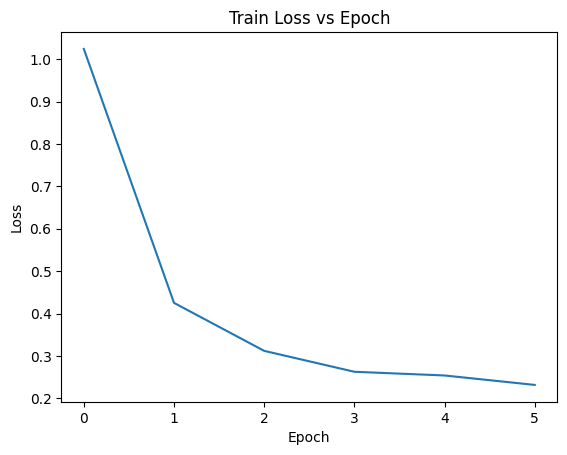

In [35]:
plt.figure()
plt.plot(history["train_loss"])
plt.title("Train Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Step 7: Plot Accuracy vs Epoch

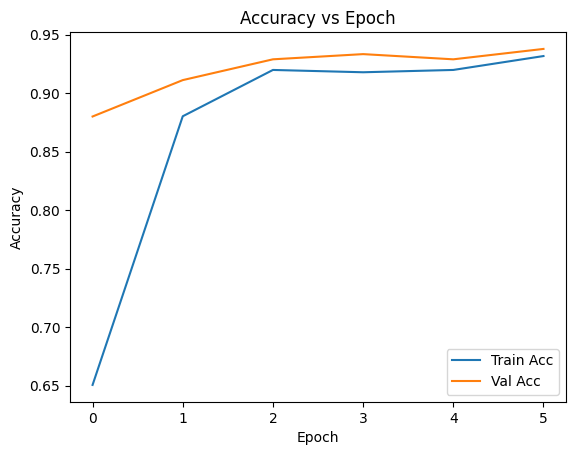

In [36]:
plt.figure()
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Step 8: Analysis of failing class

In [37]:
recall_sorted = sorted(recall_per_class.items(), key=lambda x: x[1])
failing_class = recall_sorted[0][0]

print("Worst performing class:", failing_class)
print("Recall:", round(recall_sorted[0][1], 3))

improvement_suggestions = [
    "Add more images for this class",
    "Unfreeze last ResNet block and fine-tune",
    "Lower learning rate to 1e-4",
    "Add stronger augmentation for this class"
]

print("Suggested improvements:")
for s in improvement_suggestions:
    print("-", s)

Worst performing class: tomato_early_blight
Recall: 0.933
Suggested improvements:
- Add more images for this class
- Unfreeze last ResNet block and fine-tune
- Lower learning rate to 1e-4
- Add stronger augmentation for this class
